<a href="https://colab.research.google.com/github/Subangkar/Image-Captioning-Attention-PyTorch/blob/main/demo_attention_flickr8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

###Fetch Dataset & Codes from GitHub


In [2]:
%%shell
sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (2,863 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 145480 files and directories c

In [3]:
%%capture
!pip install wandb
!pip install kora

In [14]:
import os

# https://drive.google.com/drive/folders/16e_bNz92M5g3Myp2kKbGZcXIkDTjasP-?usp=sharing

if not os.path.exists('saved_models'):
    from kora import drive
    drive.download_folder('16e_bNz92M5g3Myp2kKbGZcXIkDTjasP-')

1LgVuD3I_I24o6IgtZK16M_2f3g3Y03yQ .gitignore application/octet-stream (1/4)
1YcEPyoVwedlDRDeYF1o-s41H2QaBEOIj resnet101_attention_frozenENC_trainEMBD_rmsprop_b128_emdGLV300 application/vnd.google-apps.folder (2/4)
1iJMitwV2RCUtjDrMMmmMtD4uqJydlVfa resnet101_attention_frozenENC_trainEMBD_rmsprop_b128_emdGLV300_best_train.pt application/octet-stream (1/3)
Download 100%.
11A0cGUKYr6BFDm9O4AnEiLGVNWbIzyLS resnet101_attention_frozenENC_trainEMBD_rmsprop_b128_emdGLV300_best_val.pt application/octet-stream (2/3)
Download 100%.
1PRjakH2piTLCVP06EWfYkYgK_yXV61tr vocab_set.pkl application/octet-stream (3/3)
Download 100%.
1ik0w3tlTbUJdp3ivMtt8Ww19dErOmZ_D resnet101_attention_trainENC_trainEMBD_rmsprop application/vnd.google-apps.folder (3/4)
1BrQK-r5DPBkxxdlUEGP6OTiJJjaeP7Tm resnet101_attention_trainENC_trainEMBD_rmsprop-1_b32_emdGLV300_best_train.pt application/octet-stream (1/2)
Download 100%.
13NenGDftGimmt7N2MwuuysN2fWRJ_nP3 vocab_set.pkl application/octet-stream (2/2)
Download 100%.
10F97P_

In [4]:
%%shell

if [ ! -f "train_attntn.py" ]
then
    git clone https://github.com/Subangkar/Image-Captioning-Attention-PyTorch/
    mv Image-Captioning-Attention-PyTorch/* .
    rm -r Image-Captioning-Attention-PyTorch
fi


Cloning into 'Image-Captioning-Attention-PyTorch'...
remote: Enumerating objects: 456, done.
remote: Counting objects: 100% (456/456), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 456 (delta 246), reused 456 (delta 246), pack-reused 0
Receiving objects: 100% (456/456), 1.05 MiB | 30.73 MiB/s, done.
Resolving deltas: 100% (246/246), done.


In [ ]:
# %%capture
%%shell
mkdir -p data/flickr8k/
if [ ! -f "data/flickr8k/Flickr8k_Dataset.zip" ]
then
    wget "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip" -O "data/flickr8k/Flickr8k_Dataset.zip"
    wget "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip" -O "data/flickr8k/Flickr8k_text.zip"
fi

if [ ! -d "data/flickr8k/Flicker8k_Dataset" ]
then
    unzip "data/flickr8k/Flickr8k_Dataset.zip" -d data/flickr8k/
fi

if [ ! -d "data/flickr8k/Flickr8k_text" ]
then
    unzip "data/flickr8k/Flickr8k_text.zip" -d data/flickr8k/Flickr8k_text
    rm -r "data/flickr8k/Flickr8k_text/__MACOSX"
fi

if [ -d "data/flickr8k/__MACOSX" ]
then
    rm -r "data/flickr8k/__MACOSX"
fi
mkdir -p saved_models


In [6]:
%%shell

if [ ! -f "data/glove.6B.zip" ]
then
    wget "http://nlp.stanford.edu/data/glove.6B.zip" -O "data/glove.6B.zip"
fi

if [ ! -d "data/glove.6B" ]
then
    unzip "data/glove.6B.zip" -d "data/glove.6B"
fi


--2020-12-29 17:26:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-29 17:26:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-29 17:26:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘data/glove.6B.zip’

da

###Setup Depencencies

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Demo

In [9]:
MODEL_DIR = 'saved_models/resnet101_attention_frozenENC_trainEMBD_rmsprop_b128_emdGLV300/'
MODEL_NAME = 'resnet101_attention_frozenENC_trainEMBD_rmsprop_b128_emdGLV300_best_train.pt'

In [10]:
import os
import pickle
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets.flickr8k import Flickr8kDataset
from metrics import *
from utils_torch import *
from utils_plot import visualize_att

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [12]:
DATASET_BASE_PATH = 'data/flickr8k/'

In [15]:
vocab_set = pickle.load(open(MODEL_DIR+'vocab_set.pkl', 'rb')) if os.path.exists(MODEL_DIR+'vocab_set.pkl') else None
vocab, word2idx, idx2word, max_len = vocab_set
vocab_size = len(vocab)
vocab_size, max_len

(7707, 40)

In [16]:
val_set = Flickr8kDataset(dataset_base_path=DATASET_BASE_PATH, dist='val', vocab_set=vocab_set, device=device,
                          return_type='corpus',
                          load_img_to_memory=False)
test_set = Flickr8kDataset(dataset_base_path=DATASET_BASE_PATH, dist='test', vocab_set=vocab_set, device=device,
                           return_type='corpus',
                           load_img_to_memory=False)
train_eval_set = Flickr8kDataset(dataset_base_path=DATASET_BASE_PATH, dist='train', vocab_set=vocab_set, device=device,
                                 return_type='corpus',
                                 load_img_to_memory=False)
len(train_eval_set), len(val_set), len(test_set)

(6000, 1000, 1000)

In [17]:
EMBEDDING_DIM = 300
ATTENTION_DIM = 256
DECODER_SIZE = 256
BATCH_SIZE = 16

In [18]:
checkpoint = torch.load(os.path.join(MODEL_DIR, MODEL_NAME))

In [19]:
def evaluate_model(data_loader, model, loss_fn, vocab_size, bleu_score_fn, tensor_to_word_fn, desc=''):
    running_bleu = [0.0] * 5
    model.eval()
    t = tqdm(iter(data_loader), desc=f'{desc}')
    for batch_idx, batch in enumerate(t):
        images, captions, lengths = batch
        outputs = tensor_to_word_fn(model.sample(images, startseq_idx=word2idx['<start>']).cpu().numpy())

        for i in (1, 2, 3, 4):
            running_bleu[i] += bleu_score_fn(reference_corpus=captions, candidate_corpus=outputs, n=i)
        t.set_postfix({
            'bleu1': running_bleu[1] / (batch_idx + 1),
            'bleu4': running_bleu[4] / (batch_idx + 1),
        }, refresh=True)
    for i in (1, 2, 3, 4):
        running_bleu[i] /= len(data_loader)
    return running_bleu

In [20]:
from models.torch.resnet101_attention import Captioner

final_model = Captioner(encoded_image_size=14, encoder_dim=2048,
                        attention_dim=ATTENTION_DIM, embed_dim=EMBEDDING_DIM, decoder_dim=DECODER_SIZE,
                        vocab_size=vocab_size,).to(device)
final_model.load_state_dict(checkpoint['state_dict'])
final_model.eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Captioner(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
         

In [21]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=train_eval_set.pad_value).to(device)
sentence_bleu_score_fn = bleu_score_fn(4, 'sentence')
corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')
tensor_to_word_fn = words_from_tensors_fn(idx2word=idx2word)

eval_transformations = transforms.Compose([
    transforms.Resize(256),  # smaller edge of image resized to 256
    transforms.CenterCrop(256),  # get 256x256 crop from random location
    transforms.ToTensor(),  # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),  # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
])

val_set.transformations = eval_transformations
test_set.transformations = eval_transformations
train_eval_set.transformations = eval_transformations

In [22]:
eval_collate_fn = lambda batch: (torch.stack([x[0] for x in batch]), [x[1] for x in batch], [x[2] for x in batch])
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                        collate_fn=eval_collate_fn)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                         collate_fn=eval_collate_fn)
train_eval_loader = DataLoader(train_eval_set, batch_size=BATCH_SIZE, shuffle=False, sampler=None, pin_memory=False,
                               collate_fn=eval_collate_fn)

In [23]:
model = final_model
model.eval()

Captioner(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
         

References: ['A man in an orange shirt and a blue hardhat smiles .', 'A man smiling with a helmet on his head .', 'A man wearing a helmet and sunglasses smiles .', 'A man wearing an orange shirt and helmet .', 'A man with a blue helmet and orange shirt .']
pred: a man wearing a helmet and sunglasses . 


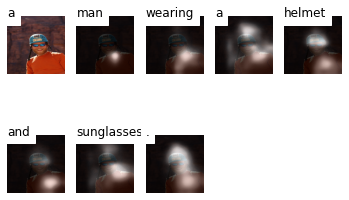

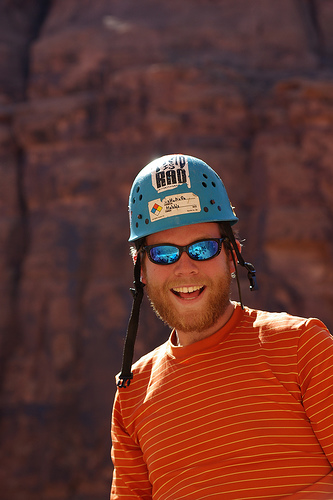

In [24]:
t_i = 100
dset = train_eval_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)
visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

References: ['A bicyclist with a green shirt rides through the woods', 'A man in green biking in the woods .', 'A man is riding a mountain bike on a woodland trail .', 'A man rides a bike through a wooded trail .', 'A mountain biker is riding along a heavy dirt trail in a wooded area .']
pred: a person on a bike is jumping in the air on a dirt bike . 


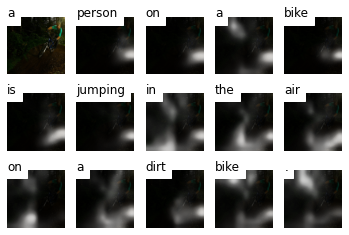

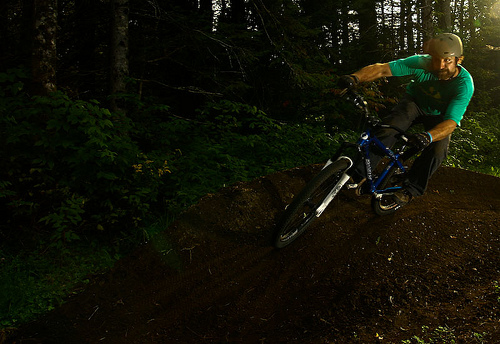

In [25]:
t_i = 500
dset = val_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)
visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

References: ['A man in black shorts is jumping off planks of wood .', 'A man is diving off logs while wearing all black gear .', 'A man jumping off of some logs .', 'A man jumps off a wooden structure .', 'A man with a black shirt jumps from a wooden plank on a cloudy day .']
pred: a young man jumps off of a platform . 


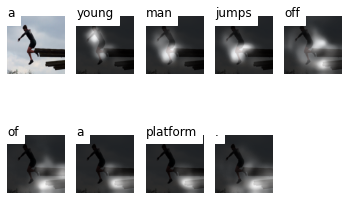

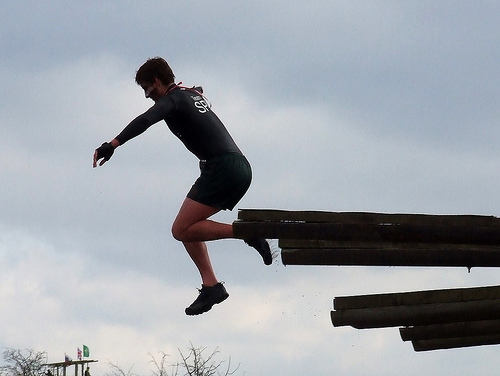

In [26]:
t_i = 500
dset = test_set
im, cp, _ = dset[t_i]
capidx, alpha = model.sample(im.unsqueeze(0), word2idx['<start>'], return_alpha=True)
capidx = capidx[0].detach().cpu().numpy()
alpha = alpha[0].detach().cpu()
print('References:', dset.get_image_captions(t_i)[1])
caption_pred=''.join(list(itertools.takewhile(lambda word: word.strip() != '<end>',
                                                         map(lambda idx: idx2word[idx]+' ', iter(capidx)))))
print(f'pred:', caption_pred)
visualize_att(dset.get_image_captions(t_i)[0], capidx, alpha, idx2word)
Image.open(dset.get_image_captions(t_i)[0])

In [27]:
with torch.no_grad():
    model.eval()
    train_bleu = evaluate_model(desc=f'Train: ', model=final_model,
                                loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                                tensor_to_word_fn=tensor_to_word_fn,
                                data_loader=train_eval_loader, vocab_size=vocab_size)
    val_bleu = evaluate_model(desc=f'Val: ', model=final_model,
                              loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                              tensor_to_word_fn=tensor_to_word_fn,
                              data_loader=val_loader, vocab_size=vocab_size)
    test_bleu = evaluate_model(desc=f'Test: ', model=final_model,
                               loss_fn=loss_fn, bleu_score_fn=corpus_bleu_score_fn,
                               tensor_to_word_fn=tensor_to_word_fn,
                               data_loader=test_loader, vocab_size=vocab_size)
    for setname, result in zip(('train', 'val', 'test'), (train_bleu, val_bleu, test_bleu)):
        print(setname, end=' ')
        for ngram in (1, 2, 3, 4):
            print(f'Bleu-{ngram}: {result[ngram]}', end=' ')
        print()


train Bleu-1: 0.7579743440429667 Bleu-2: 0.5987030989046861 Bleu-3: 0.47295082735126953 Bleu-4: 0.37383042929456134 
val Bleu-1: 0.5989312046239269 Bleu-2: 0.3876890825534746 Bleu-3: 0.2511582276053725 Bleu-4: 0.15907501959585327 
test Bleu-1: 0.6018721587274067 Bleu-2: 0.3899140965683851 Bleu-3: 0.2556496127016403 Bleu-4: 0.16729212943566896 
